In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices, dmatrix
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import numpy as np
#from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense, Activation
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

seed = 5
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
lc_2015 = pd.read_csv('lc_2015.csv', header=1, low_memory=False)
lc_2015_dec = pd.read_csv('lc_2015_dec.csv', header=1, low_memory=False)

In [3]:
lc_2015['grade'].value_counts()

C    120567
B    117606
A     73336
D     62654
E     34948
F      9817
G      2167
Name: grade, dtype: int64

In [4]:
lc_d_2015 = lc_2015[(lc_2015['grade']!='D')
                   & (lc_2015['grade']!='E')
                   & (lc_2015['grade']!='F')
                   & (lc_2015['grade']!='G')
                   & (lc_2015['term']==' 36 months')
                   & ((lc_2015['loan_status']=='Fully Paid') | (lc_2015['loan_status']=='Charged Off'))
                   ].copy()

lc_d_2015.reset_index(inplace=True)

In [5]:
lc_d_2015['loan_status'].value_counts()/np.sum(lc_d_2015['loan_status'].value_counts())

Fully Paid     0.875603
Charged Off    0.124397
Name: loan_status, dtype: float64

In [6]:
lc_d_2015['grade'].value_counts()

B    91725
C    77423
A    70118
Name: grade, dtype: int64

In [7]:
# Clean up the dataframe

# Make my outcome variable 0s and 1s
outcome_var = []
for i in lc_d_2015['grade']:
    if i == 'A':
        outcome_var.append(1)
    else:
        outcome_var.append(0)
lc_d_2015['outcome_var'] = outcome_var

# Find all the mths_since columns
mths_since_list = [i for i in lc_d_2015.columns if 'mths_since' in i]

# Bin the mths_since columns to make them valid inputs
for col in mths_since_list:
    if col != 'sec_app_mths_since_last_major_derog':
        category = list(pd.cut(lc_d_2015[col], bins=4, labels=['0', '1', '2', '3']))
        for i, val in enumerate(category):
            if type(val) != str:
                if np.isnan(val):
                    category[i] = '4'
    lc_d_2015[col + '_cat'] = category
    
# Replace nulls in columns with strings (i.e. if no job title, replace null with 'none')
ok_list = ['emp_title','emp_length']
for col in ok_list:
    new_list = []
    col_values = list(lc_d_2015[col])
    for i, val in enumerate(col_values):
        if type(val) != str:
            if np.isnan(val):
                new_list.append('none')
            else:
                new_list.append(val)
        else:
            new_list.append(val)
    new_col_name = col + '_2'
    lc_d_2015[new_col_name] = new_list

In [8]:
# Count the nulls for each column and store each count in a dictionary (keys = column name)
def count_null(df):
    null_dict = {}
    for i in df.columns:
        if i in null_dict:
            null_dict[i] += sum([1 for j in lc_d_2015[i].isna() if j])
        else:
            null_dict[i] = sum([1 for j in lc_d_2015[i].isna() if j])
    return null_dict

null_dict = count_null(lc_d_2015)

In [9]:
# Check df shape before dropping nulls
lc_d_2015.shape

(239266, 158)

In [10]:
# Drop nulls
for key, val in null_dict.items():
    if val >= 10000:
        lc_d_2015.drop(labels=key, axis=1, inplace=True)
        
null_dict2 = count_null(lc_d_2015)

lc_d_2015.dropna(inplace=True)
lc_d_2015.shape

(228998, 96)

In [11]:
lc_d_2015['loan_status'].value_counts()

Fully Paid     200746
Charged Off     28252
Name: loan_status, dtype: int64

In [12]:
#Include?        	LoanStatNew
#Keep for agg    	id
#Maybe           	last_pymnt_amnt
#Maybe           	last_pymnt_d
#Outcome         	loan_status
#Keep for agg    	member_id
#Maybe           	sub_grade
#Category        	zip_code
#Like Outcome    	debt_settlement_flag
store_list = ['last_pymnt_amnt','last_pymnt_d','loan_status','sub_grade','zip_code','debt_settlement_flag']
kept_df = lc_d_2015[store_list].copy()

remove_list = ['collection_recovery_fee',
               #'grade',                  # <- decided to keep grade in
               'initial_list_status',
               'next_pymnt_d',
               'policy_code',
               'title',
               'url',
               'payment_plan_start_date',
               'orig_projected_additional_accrued_interest',
               'debt_settlement_flag_date',
               'settlement_date']

for i in remove_list:
    if i in lc_d_2015.columns:
        lc_d_2015.drop(labels=i, axis=1, inplace=True)

In [13]:
# More cleaning and feature engineering

convert_list = ['int_rate','revol_util']
for col in convert_list:
    new_list = []
    new_name = col + '_float'
    for i in lc_d_2015[col]:
        if col != 'revol_util':
            new_list.append(float(re.findall(r'\d+\.\d+', i)[0])/100)
        else:
            new_list.append(float(re.findall(r'\d+', i)[0])/100)
    lc_d_2015[new_name] = new_list

emp_length_int = []
for i in lc_d_2015['emp_length_2']:
    if i == 'none':
        emp_length_int.append(0)
    else:
        emp_length_int.append(int(re.findall(r'\d+', i)[0]))
lc_d_2015['emp_length_int'] = emp_length_int

earliest_cr_yrs = []
for i in lc_d_2015['earliest_cr_line']:
    earliest_cr_yrs.append(2019 - int(re.findall(r'\d+', i)[0]))
lc_d_2015['earliest_cr_yrs'] = earliest_cr_yrs

own_home = []
for i in lc_d_2015['home_ownership']:
    if i == 'OWN':
        own_home.append(1)
    else:
        own_home.append(0)
lc_d_2015['own_home'] = own_home

In [14]:
# Figure out the features I want in my model
model_cols = ['outcome_var',
              'loan_amnt', 'annual_inc', 'own_home',
              'verification_status', 'issue_d', 'purpose', 'addr_state', 
              'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
              'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
              'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
              'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
              'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
              'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
              'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
              'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
              'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
              'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
              'mths_since_last_record_cat', 'mths_since_last_major_derog_cat', 'mths_since_rcnt_il_cat',
              'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat', 'mths_since_recent_inq_cat',
              'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

model_data = lc_d_2015[model_cols].copy()

In [15]:
# Cluster Analysis

from sklearn.cluster import KMeans

cluster_cols = ['emp_length_int', 'annual_inc', 'verification_status', 'purpose', 'own_home']

# Add interactions
cluster_str = cluster_cols[0]
for i in cluster_cols[1:]:
    cluster_str = cluster_str + ' + ' + i

cluster_patsy = dmatrix(cluster_str, model_data)

cluster_model = KMeans(n_clusters=5)
cluster_model.fit(cluster_patsy)
my_clusters = ['group_' + str(i) for i in cluster_model.labels_]

model_data['my_clusters'] = my_clusters

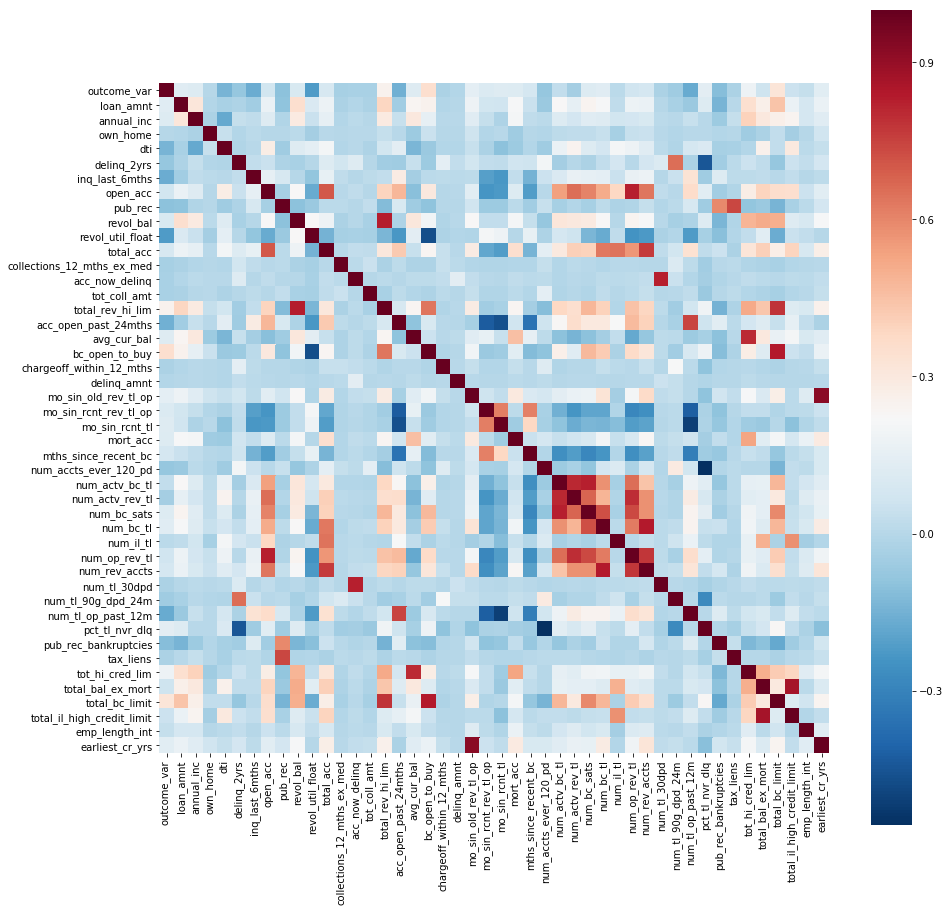

In [16]:
# Plot the correlation matrix
corrs = model_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrs, square=True, cmap="RdBu_r");
plt.savefig(fname='corr_matrix', dpi=150)

In [19]:
# Use Patsy to create my X Matrix
x_cols = ['my_clusters', 'loan_amnt', 'own_home', 'annual_inc',
          'verification_status', 'issue_d', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
          'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
          'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
          'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
          'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
          'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
          'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
          'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
          'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
          'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
          'mths_since_last_record_cat', 'mths_since_last_major_derog_cat',
          'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat',
          'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '+ loan_amnt*revol_util_float + revol_util_float*revol_bal'

x_patsy = dmatrix(x_str, model_data)
print(x_patsy.shape)

(228998, 88)


In [20]:
# Stratified train test split
x_raw = x_patsy
y_raw = np.array(model_data['outcome_var'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_mid, x_test = x_raw[train_index,:], x_raw[test_index,:]
    y_mid, y_test = y_raw[train_index], y_raw[test_index]

sss2.get_n_splits()
for train_index, test_index in sss2.split(x_mid, y_mid):
    x_train, x_val = x_mid[train_index,:], x_mid[test_index,:]
    y_train, y_val = y_mid[train_index], y_mid[test_index]

In [21]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(x_train)
x_norm_train = scaler.transform(x_train)
x_norm_val = scaler.transform(x_val)
x_norm_test = scaler.transform(x_test)
x_norm_mid = scaler.transform(x_mid)

# Change intercept back to 1
# x_norm_train[:,0] = 1
# x_norm_val[:,0] = 1
# x_norm_test[:,0] = 1

In [22]:
# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [23]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 700]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 74.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 83.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 94.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 107.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 153.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 168.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15], 'max_features': ['sqrt'], 'min_samples_leaf': [10, 20], 'min_samples_split': [2, 5], 'n_estimators': [500, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [24]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(x_norm_train, y_train)

In [25]:
#print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
#print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for logit: 0.8352
Best ROC_AUC for rf: 0.8465


In [26]:
#print('Best Params for knn: ', knn_grid.best_params_)
print('Best Params for logit: ', logistic_grid.best_params_)
#print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

Best Params for logit:  {'C': 1.0, 'penalty': 'l2'}
Best Params for rf:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 700}


In [27]:
# Fit Dummy Classifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(x_norm_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

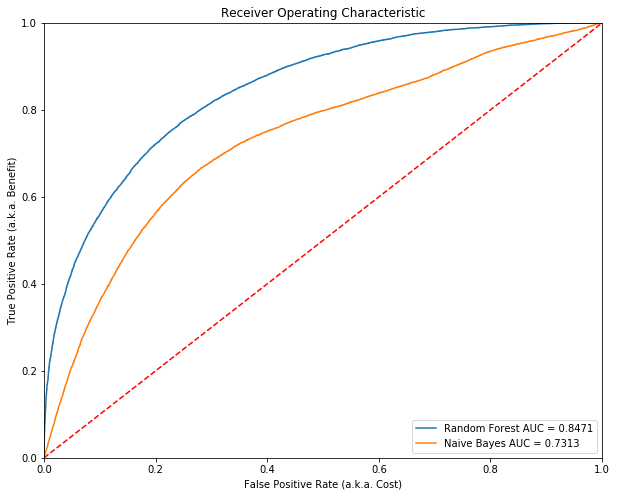

In [34]:
# ROC for testing

model_list = [rf_grid.best_estimator_,
              gnb_best]
model_name = ['Random Forest', 'Naive Bayes']


# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.60
        w2 = 0.30
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(x_norm_val)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(x_norm_val)[:,1]
                  + (1-w1-w2)*gnb_best.predict_proba(x_norm_val)[:,1])
    else:
        y_pred = list(model.predict_proba(x_norm_val)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (a.k.a. Benefit)')
plt.xlabel('False Positive Rate (a.k.a. Cost)')
plt.savefig(fname='ROC_Example', dpi=150)
plt.show()

In [29]:
# logistic_A = linear_model.LogisticRegression(solver='lbfgs', C=3500, max_iter=10000, n_jobs=-1, verbose=10)
# logistic_A.fit(x_norm_mid, y_mid)
rf_A = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=10, 
                              min_samples_split=5, n_estimators=500)
rf_A.fit(x_norm_mid, y_mid)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
# Pickle the trained model
file = open('prob_A_model', 'wb')
pickle.dump(rf_A, file)
file.close()